In [1]:
import glob
import shutil
import os
# - Training

# ID058 : labeling 잘못됨                          <<<<<<

# ID073 : 손가락 끝에 점이 보임
# ID288 : 손가락 끝에 점이 보임
# ID360 image1664935401873: 검지 끝부분 뼈 모양 이상(?)
# ID363 image1664935962797: 반지,붕대 같은거        <<<<<<
# ID387 : 손톱에 표시                               <<<<<<
# ID409 image1665540974169: 검지 끝부분 모양 이상(?)
# ID430 : 선 같은게 보임(?)
# ID487 image1666661955150 : 철심                   <<<<<<
# ID519 : 엄지 끝 부분 흰 점(?)
# ID523 : 손가락 끝에 점이 보임
# ID543 : 손가락 끝에 점이 보임(희미함)

# 274~ 319, 321 : 양쪽으로 손을 튼 사진
os.makedirs("noise_data/train/DCM")
os.makedirs("noise_data/train/outputs_json")

In [9]:
noise = ["ID058","ID363", "ID487", "ID387"]
for n in noise:
    img_dir = "/opt/ml/data/train/DCM/"
    label_dir = "/opt/ml/data/train/outputs_json/"
    img_origin = os.path.join(img_dir, n)
    label_dir = os.path.join(label_dir, n)
    shutil.move(img_origin, img_origin.replace("data", "noise_data"))
    shutil.move(label_dir, label_dir.replace("data", "noise_data"))

In [1]:
import ttach as tta

# transforms = tta.Compose(
#     [
#         tta.HorizontalFlip(),
#         # tta.Rotate90(angles=[0, 30])
#         tta.Scale(scales=[0.5, 0.8, 1]), 
#         tta.Multiply(factors=[0.5, 0.8, 1]),        
#     ]
# )
transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            # tta.Rotate90(angles=[0, 30]),
            # tta.Resize(sizes=[(1280, 1280), (1536, 1536)], original_size=(2048, 2048)),
            # tta.Multiply(factors=[1, 0.8])
        ]
    )

In [2]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [3]:
from utils import CLASSES, read_json
import models
import torch
import os 
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import augmentations
from datasets import XRayInferenceDataset
from utils import CLASSES, IND2CLASS, encode_mask_to_rle, set_seed
import collections
import torch
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
tta_models = []

In [4]:
def tta_model(config_path):
    config = read_json(config_path)
    if os.path.splitext(config.inference_model_dir)[1] == ".pt":
        model = torch.load(config.inference_model_dir)
    else:
        if config.base.use == "smp":
            model = getattr(smp, config.base.smp.model)(
                encoder_name=config.base.smp.encoder_name,
                encoder_weights=config.base.smp.encoder_weights,
                in_channels=3 if not config.gray else 1,
                classes=len(CLASSES),
            )
        else:
            model = getattr(models, config.base.pytorch.model)(len(CLASSES), 3 if not config.gray else 1)
        model.load_state_dict(
            torch.load(os.path.join(config.save_model_dir, config.model_file_name))['model_state_dict']
        )
    tta_model = tta.SegmentationTTAWrapper(model, transforms, merge_mode="mean")
    return tta_model

In [12]:
import torch

In [3]:
model = torch.load("/opt/ml/level2_cv_semanticsegmentation-cv-08/model_dir/fcn_resnet50_1024/fcn_resnet50_best_model_epoch-69_0.9678.pt")

In [4]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
    },
    "fcn_resnet50_1024.pth")

In [34]:
import models
model =models.fcn_resnet50(29, 3)

In [35]:
weights = torch.load("/opt/ml/level2_cv_semanticsegmentation-cv-08/fcn_resnet50_1024.pth")

In [28]:
list(weights['model_state_dict'].keys())[0].split('.')[0] == "model"

False

In [37]:
weights = {'model.' + k : v for k, v in weights['model_state_dict'].items()}

In [38]:
model.load_state_dict(weights)

<All keys matched successfully>

In [6]:
config_path_1 = "/opt/ml/level2_cv_semanticsegmentation-cv-08/model_dir/regnety_320_1024_batch-16_copypaste/config.json"
config_path_2 = "/opt/ml/level2_cv_semanticsegmentation-cv-08/model_dir/fcn_resnet50_2048_multi-batch/config.json"
regnet_1024 = tta_model(config_path_1)
fcn_resnet50_2048 = tta_model(config_path_2)

In [42]:
tta_models

[SegmentationTTAWrapper(
   (model): UnetPlusPlus(
     (encoder): RegNetEncoder(
       (stem): ConvNormAct(
         (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
         (bn): BatchNormAct2d(
           32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
           (drop): Identity()
           (act): ReLU(inplace=True)
         )
       )
       (s1): RegStage(
         (b1): Bottleneck(
           (conv1): ConvNormAct(
             (conv): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
             (bn): BatchNormAct2d(
               232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
               (drop): Identity()
               (act): ReLU(inplace=True)
             )
           )
           (conv2): ConvNormAct(
             (conv): Conv2d(232, 232, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
             (bn): BatchNormAct2d(
               232, eps=1e-05, momentum=0.1

In [7]:
dataset_config_path = "/opt/ml/level2_cv_semanticsegmentation-cv-08/model_dir/fcn_resnet50_2048_multi-batch/config.json"
dataset_config = read_json(dataset_config_path)

# Augmentation
tf = getattr(augmentations, dataset_config.test.augmentations.name)(
    **dataset_config.test.augmentations.parameters
)

# Dataset
test_dataset = XRayInferenceDataset(dataset_config, transforms=tf)

# Dataloader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=dataset_config.test.batch_size,
    shuffle=False,
    num_workers=dataset_config.test.num_workers,
    drop_last=False,
)

In [8]:
images, image_names = next(iter(test_loader))
model=tta_models[0]
model = model.cuda()
model.eval()
images = images.float().cuda()
with torch.no_grad():
    out = model(images)
out = F.interpolate(out, size=(2048, 2048), mode="bilinear")
out = torch.sigmoid(out)

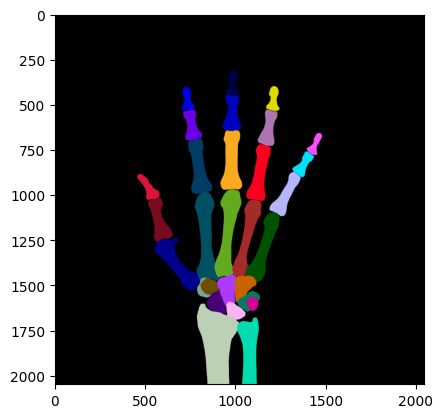

In [12]:
out_final = (out > 0.6).detach().cpu().numpy()
plt.imshow(label2rgb(out_final.squeeze()))

In [15]:
import torch
import numpy as np
import albumentations as A
import torch.nn.functional as F
x = torch.rand(2,3,2048,2048)
x2 = x[:, 0, : , :].unsqueeze(1)
x3 = F.interpolate(input = x2, size=(1024, 1024))

In [17]:
x3.size()

torch.Size([2, 1, 1024, 1024])

In [19]:
x3[:, :, [1,3,4], :].shape

torch.Size([2, 1, 3, 1024])

In [8]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [9]:
classes = ["Trapezoid", "Hamate", "Lunate", "Triquetrum", "Pisiform", "Capitate", "Trapezium"]

In [12]:
regnet_1024 = regnet_1024.cuda()
regnet_1024.eval()
fcn_resnet50_2048 = fcn_resnet50_2048.cuda()
fcn_resnet50_2048.eval()

SegmentationTTAWrapper(
  (model): fcn_resnet50(
    (model): FCN(
      (backbone): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, mome

In [13]:
import albumentations as A
import torch.nn.functional as F
rles = []
filename_and_class = []
with torch.no_grad():
    for step, (images, image_names) in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.float().cuda()
        images_gray = F.interpolate(images[:, 0, :, :].unsqueeze(1), size=(1024,1024))
        outputs = regnet_1024(images_gray)
        outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
        fcn_resnet50_output = fcn_resnet50_2048(images)
        for fcn_class in classes:
            class_index = CLASS2IND[fcn_class]
            outputs[:, class_index, :, :] = fcn_resnet50_output[:, class_index, :, :]
        # restore original size
        outputs = torch.sigmoid(outputs)
        outputs = (outputs > 0.5).detach().cpu().numpy()

        for output, image_name in zip(outputs, image_names):
            for c, segm in enumerate(output):
                rle = encode_mask_to_rle(segm)
                rles.append(rle)
                filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")

100%|██████████| 150/150 [09:09<00:00,  3.66s/it]


In [14]:
# set_seed(config.seed)
# model = model.cuda()
# model.eval()

rles = []
filename_and_class = []
with torch.no_grad():
    for step, (images, image_names) in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        outputs = []
        images = images.float().cuda()
        for n, model in enumerate(tta_models): 
            model = model.cuda()
            model.eval()
            output = model(images)
            if isinstance(output, collections.OrderedDict):
                output = output["out"]
            outputs.append(output)
        outputs = torch.stack(outputs, dim=0).sum(dim=0) / len(tta_models)        
        # restore original size
        outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
        outputs = torch.sigmoid(outputs)
        outputs = (outputs > 0.5).detach().cpu().numpy()

        for output, image_name in zip(outputs, image_names):
            for c, segm in enumerate(output):
                rle = encode_mask_to_rle(segm)
                rles.append(rle)
                filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")

100%|██████████| 300/300 [04:26<00:00,  1.13it/s]


In [14]:
import pandas as pd
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]

df = pd.DataFrame(
    {
        "image_name": image_name,
        "class": classes,
        "rle": rles,
    }
)

# print(f"save csv directory : {os.path.join(config.save_model_dir, 'output.csv')}")
df.to_csv("ensemble_tta_fcn-resnet50_unet++-regnety-320.csv", index=False)


In [12]:
output = [torch.ones((29, 512, 512)), torch.ones((29, 512, 512)), torch.ones((29, 512, 512))]
output = torch.stack(output)

In [16]:
output.sum(dim=0) / 3

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1., 

In [ ]:
torch.sum()